In [1]:
%matplotlib inline

from __future__ import print_function

import math
import cmath
import re
import os
import glob
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True

# NOTES
NOTES = ""

# Vars
target_label = "Survived"
id_label = "PassengerId"
CORR_THRESH = 0.3
TITLES = []
TYPE = "DNN"
OUTSTR = "A{:.2f}_C{:.2f}_Type{}_F{}{}.csv"

FEATURES = ["Age", "Pclass", "Male", "HasCabin", "Fare", "NumFamily", "Embarked"]

# PATHS
paths = {
    "Training":"/home/wesleytocs/.kaggle/competitions/titanic/train.csv",
    "Testing":"/home/wesleytocs/.kaggle/competitions/titanic/test.csv",
    "Submission":"/home/wesleytocs/.kaggle/competitions/titanic/gender_submission.csv",
}

def classify(x):
    return (1 if x >= THRESHOLD else 0)

def find_na(df):
    l = []
    for label in df.columns:
        if df[label].dropna().shape[0] != df.shape[0]:
            l.append(label)
    return l

def numerical_labels(df):
    l = []
    for label in df.columns:
        if df[label].dtype in ["int32", "float32", "float64", "int64"]:
            l.append(label)
    return l

def square_root(series):
    return series.apply(lambda x:math.sqrt(x))

def log_normalize(series, base=10):
    return series.apply(lambda x:math.log(x, base))

def clip(series, clip_to_min, clip_to_max):
    return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
    mean = series.mean()
    std_dv = series.std()
    return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
    return series.apply(lambda x:(1 if x > threshold else 0))

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

def get_age_from_title(title, dataframe):
    age = dataframe["Age"].mean()
    df = dataframe[dataframe["Title"] == title]
    age = df["Age"].mean()
    return age

def bucketize(val, limits=[float("inf")]):
    for i in range(len(limits)):
        if val < limits[i]:
            return i
    if val:
        return i + 1
    return i + 2 # "no value" bucket

def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

  periods = 10

  steps_per_period = steps / periods  
  # Create the input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets[target_label], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets[target_label], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, 
      validation_targets[target_label], 
      num_epochs=1, 
      shuffle=False)

  # Create a DNNClassifier object.
  my_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(training_examples),
      n_classes=2,
      hidden_units = hidden_units,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
  )

  t_acc = []
  v_acc = []

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...\n\tAccuracy:")
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    training_predictions = classifier.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['class_ids'][0] for item in training_predictions])
    
    validation_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['class_ids'][0] for item in validation_predictions])
    
    t_accuracy = accuracy_score(training_targets, training_predictions)
    v_accuracy = accuracy_score(validation_targets, validation_predictions)
    t_acc.append(t_accuracy)
    v_acc.append(v_accuracy)
    print("\t\tPeriod: {}\tTest: {:.2f}\tValidation: {:.2f}".format(period, t_accuracy, v_accuracy))
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("Accuracy")
  plt.xlabel("Periods")
  plt.title("Accuracy vs. Periods")
  plt.tight_layout()
  plt.plot(t_acc, label="training")
  plt.plot(v_acc, label="validation")
  plt.legend()
  plt.show()
    
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  accuracy = accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  return (classifier, accuracy)

def preprocess_all_data(dataframe, merge=True):
    """Prepares all the data columns to be in usable formats
        (Normalizes, encodes, etc...)
    """
    global TITLES
    pattern = "[A-Z]([0-9]+)"
    def get_num(c):
        match = re.search(pattern, c)
        if match:
            return (int(match.group(1)))
    copy = dataframe.copy()
    copy["Pclass"] = copy["Pclass"].apply(lambda x: 0.0 if x == 3 else (0.5 if x == 2 else (1.0 if x == 1 else x)))
    copy["Male"] = copy["Sex"].apply(lambda x: 1.0 if x == 'male' else 0.0)
    copy["Embarked"] = copy["Embarked"].apply(lambda x: 1.0 if x == 'C' else (2.0 if x == 'Q' else 3.0))
    copy["Fare"] = copy["Fare"].apply(lambda x: bucketize(x, [0, 25, 150, 350]))
    copy["Deck"] = copy["Cabin"].apply(lambda x: "1" if "A" in str(x) else("2" if "B" in str(x) else "3" if "C" in str(x) else("4" if "D" in str(x) else ("5" if "E" in str(x) else ("6" if "F" in str(x) else ("7" if "G" in str(x) else 8))))))
    copy["NumFamily"] = copy["Parch"] + copy["SibSp"]
    copy["IsAlone"] = copy["SibSp"].apply(lambda x: 1.0 if x == 0.0 else 0.0)
    copy["Title"] = copy["Name"].apply(get_title)
    copy["HasCabin"] = copy["Cabin"].notnull().astype('int')
    copy['Title'] = copy['Title'].replace(['Lady', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    copy['Title'] = copy['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    copy['Title'] = copy['Title'].replace(['Mlle', 'Ms'], 'Miss')
    copy['Title'] = copy['Title'].replace('Mme', 'Mrs')
    titles = list(copy["Title"].unique())
    for title in titles:
        copy[title] = copy["Title"].apply(lambda x: 1.0 if x == title else 0.0)
    if merge:
        TITLES += titles
    ages = dict()
    for title in titles:
        ages[title] = get_age_from_title(title, copy)
    copy["Age"] = copy['Age'].fillna(copy["Title"].apply(lambda x: ages.get(x, -1)))
    copy["Age"] = copy["Age"].apply(lambda x: bucketize(x, [3, 10, 17, 27, 37, 50]))
    return copy

def preprocess_features(dataframe):
    labels = set(list(FEATURES) + list(CORRELATED_LABELS) + list(TITLES))
    selected_features = pd.DataFrame()
    df_labels = dataframe.columns
    for label in labels:
        if label in df_labels:
            selected_features[label] = dataframe[label].fillna(dataframe[label].mean()).astype(np.float32)
    processed_features = selected_features.copy()

    return processed_features

def preprocess_targets(dataframe):
    output_targets = pd.DataFrame()
    output_targets[target_label] = dataframe[target_label]
    return output_targets

In [2]:
dataframe = pd.read_csv(paths["Training"], sep=",")
dataframe = dataframe.reindex(np.random.permutation(dataframe.index))
if SUMMARIZE:
    print("Before Processing:")
    display.display(dataframe.describe())
dataframe = preprocess_all_data(dataframe)
corr = dataframe.corr().apply(lambda x: abs(x)).sort_values("Survived", ascending=False)["Survived"]
CORRELATED_LABELS = corr[lambda x: x > CORR_THRESH][1:].index
if SUMMARIZE:
    print("After Processing:")
    display.display(dataframe.describe())
ids = dataframe.pop(id_label)
train = preprocess_features(dataframe)
if SUMMARIZE:
    print("Training Data:")
    display.display(train.describe())

Before Processing:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,891.0,714.0,891.0,891.0,891.0
mean,446.0,0.4,2.3,29.7,0.5,0.4,32.2
std,257.4,0.5,0.8,14.5,1.1,0.8,49.7
min,1.0,0.0,1.0,0.4,0.0,0.0,0.0
25%,223.5,0.0,2.0,20.1,0.0,0.0,7.9
50%,446.0,0.0,3.0,28.0,0.0,0.0,14.5
75%,668.5,1.0,3.0,38.0,1.0,0.0,31.0
max,891.0,1.0,3.0,80.0,8.0,6.0,512.3


After Processing:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Male,NumFamily,IsAlone,HasCabin,Mr,Mrs,Miss,Master,Rare,Royal
count,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0
mean,446.0,0.4,0.3,3.7,0.5,0.4,1.4,2.5,0.6,0.9,0.7,0.2,0.6,0.1,0.2,0.0,0.0,0.0
std,257.4,0.5,0.4,1.3,1.1,0.8,0.6,0.8,0.5,1.6,0.5,0.4,0.5,0.3,0.4,0.2,0.2,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,223.5,0.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,446.0,0.0,0.0,4.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,668.5,1.0,0.5,4.0,1.0,0.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
max,891.0,1.0,1.0,6.0,8.0,6.0,4.0,3.0,1.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Training Data:


,NumFamily,Mr,Mrs,Pclass,Embarked,Miss,HasCabin,Master,Male,Age,Royal,Rare,Fare
count,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0
mean,0.9,0.6,0.1,0.3,2.5,0.2,0.2,0.0,0.6,3.7,0.0,0.0,1.4
std,1.6,0.5,0.3,0.4,0.8,0.4,0.4,0.2,0.5,1.3,0.0,0.2,0.6
min,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
50%,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0
75%,1.0,1.0,0.0,0.5,3.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0
max,10.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0,4.0


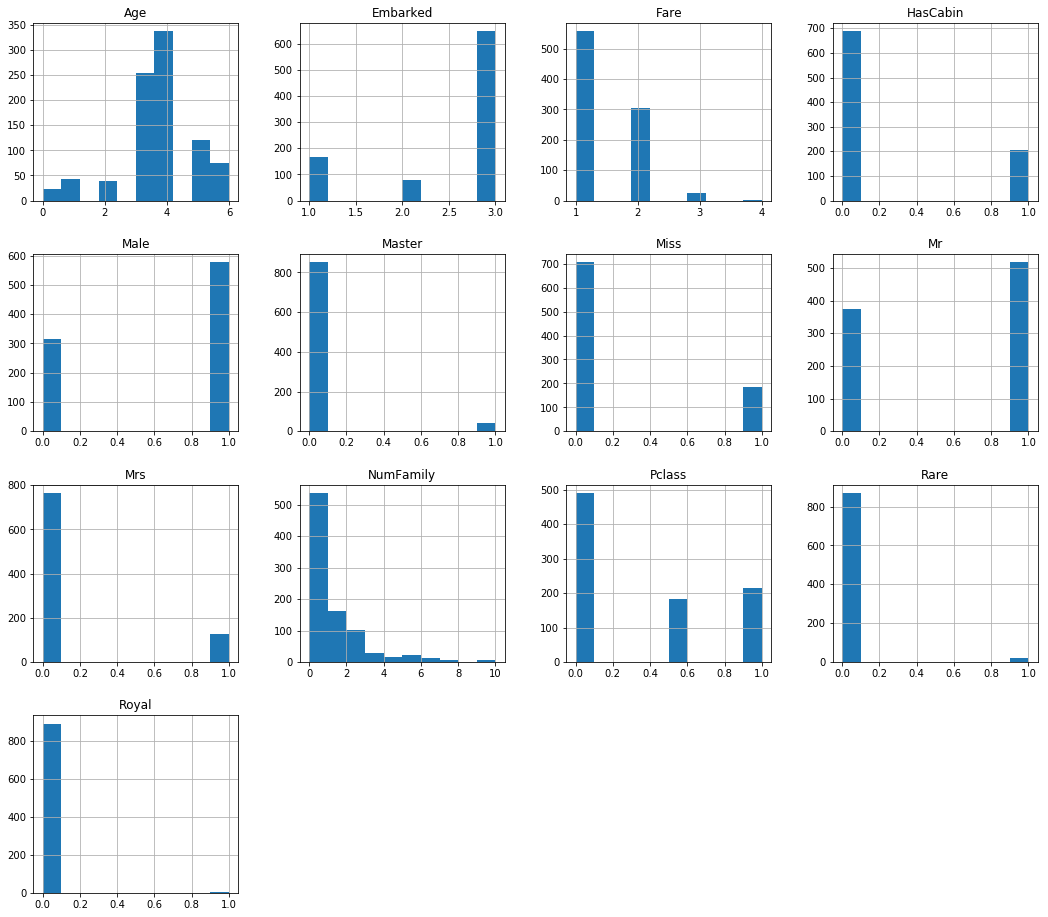

In [3]:
if PLOT:
    train.hist(figsize=(18, 16))

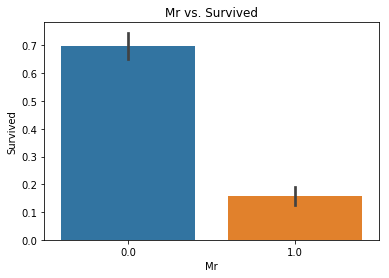

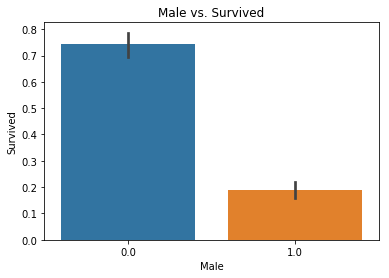

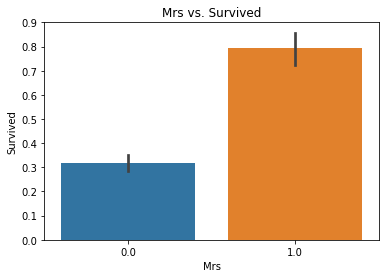

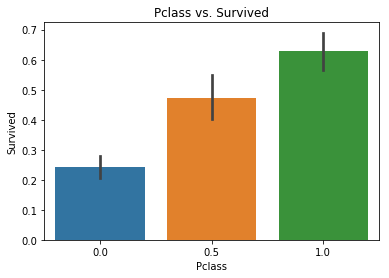

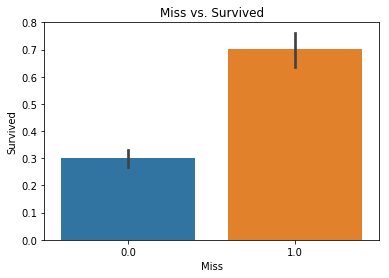

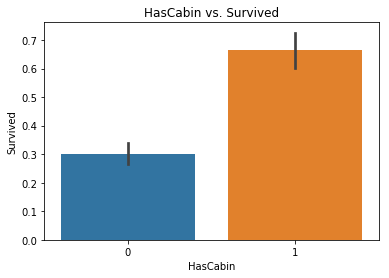

In [4]:
if PLOT:   
    for label in CORRELATED_LABELS:
        sns.barplot(x=label, y="Survived", data=dataframe)
        plt.xlabel(label)
        plt.ylabel("Survived")
        plt.title("{} vs. Survived".format(label))
        plt.show()

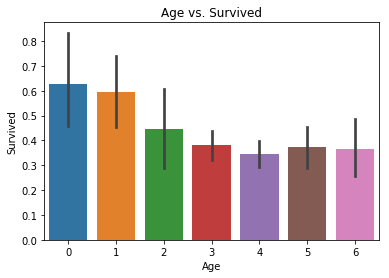

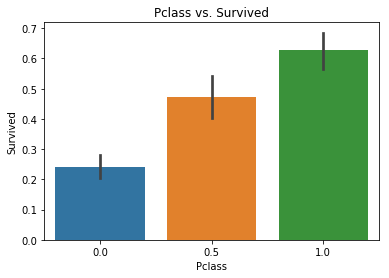

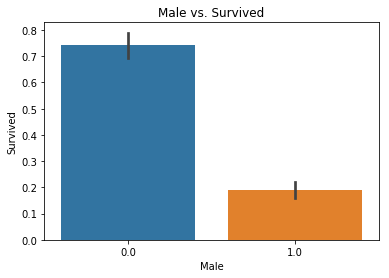

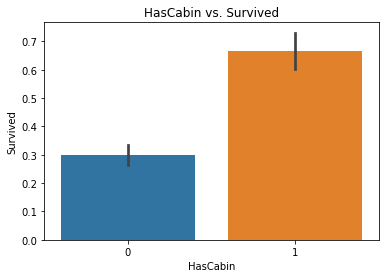

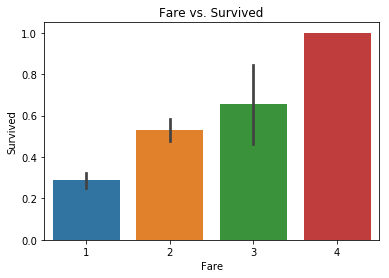

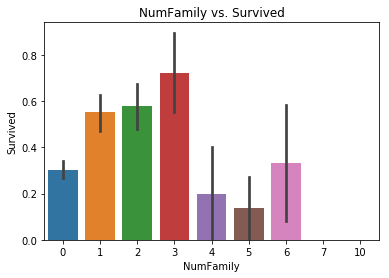

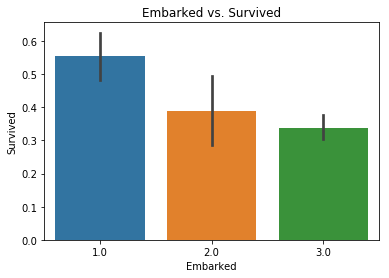

In [5]:
if PLOT:
    for label in FEATURES:
        sns.barplot(x=label, y=target_label, data=dataframe)
        plt.xlabel(label)
        plt.ylabel(target_label)
        plt.title("{} vs. {}".format(label, target_label)),
        p = dataframe[[label, target_label]].groupby([label], as_index=False).mean()
        plt.show()

In [6]:
# Split dataset 80/20 for training and validation
target = pd.DataFrame()
target[target_label] = dataframe[target_label]
df_size = dataframe.shape[0]
t_size = round(0.8 * df_size)
v_size = df_size - t_size

training_examples = train.head(t_size)
training_targets = target.head(t_size)
validation_examples = train.tail(v_size)
validation_targets = target.tail(v_size)

if SUMMARIZE:
    print("Training Data:")
    display.display(training_examples.describe())
    display.display(training_targets.describe())
    print("Validation Data:")
    display.display(validation_examples.describe())
    display.display(validation_targets.describe())
# x_train, y_train = train.head(t_size), target.head(t_size)
# x_val, y_val = train.tail(v_size), target.tail(v_size)
# num_features = train.shape[1] - 1
# randomforest = RandomForestClassifier()
# randomforest.fit(x_train, y_train)
# y_pred = randomforest.predict(x_val)
# acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_randomforest)



Training Data:


,NumFamily,Mr,Mrs,Pclass,Embarked,Miss,HasCabin,Master,Male,Age,Royal,Rare,Fare
count,713.0,713.0,713.0,713.0,713.0,713.0,713.0,713.0,713.0,713.0,713.0,713.0,713.0
mean,0.9,0.6,0.1,0.3,2.5,0.2,0.2,0.0,0.6,3.7,0.0,0.0,1.4
std,1.6,0.5,0.4,0.4,0.8,0.4,0.4,0.2,0.5,1.3,0.0,0.2,0.6
min,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
50%,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0
75%,1.0,1.0,0.0,0.5,3.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0
max,10.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0,4.0


,Survived
count,713.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation Data:


,NumFamily,Mr,Mrs,Pclass,Embarked,Miss,HasCabin,Master,Male,Age,Royal,Rare,Fare
count,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0
mean,1.0,0.5,0.1,0.4,2.5,0.2,0.3,0.1,0.6,3.6,0.0,0.0,1.5
std,1.6,0.5,0.3,0.4,0.8,0.4,0.4,0.3,0.5,1.5,0.1,0.1,0.6
min,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
50%,0.0,1.0,0.0,0.5,3.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0
75%,1.0,1.0,0.0,1.0,3.0,0.0,0.8,0.0,1.0,4.0,0.0,0.0,2.0
max,10.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0,4.0


,Survived
count,178.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Training model...
	Accuracy:
		Period: 0	Test: 0.65	Validation: 0.63
		Period: 1	Test: 0.78	Validation: 0.75
		Period: 2	Test: 0.81	Validation: 0.76
		Period: 3	Test: 0.81	Validation: 0.78
		Period: 4	Test: 0.81	Validation: 0.78
		Period: 5	Test: 0.81	Validation: 0.79
		Period: 6	Test: 0.81	Validation: 0.80
		Period: 7	Test: 0.82	Validation: 0.80
		Period: 8	Test: 0.82	Validation: 0.81
		Period: 9	Test: 0.82	Validation: 0.80
Model training finished.


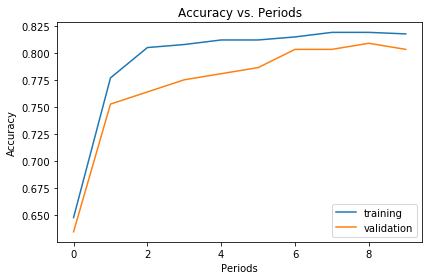

Final accuracy (on validation data): 0.80


In [7]:
classifier, accuracy = train_nn_classification_model(
              learning_rate=0.0001,
              steps=5000,
              hidden_units=[13, 10],
              batch_size=25,
              training_examples=training_examples,
              training_targets=training_targets,
              validation_examples=validation_examples,
              validation_targets=validation_targets)

In [8]:
test_data = pd.read_csv(paths["Testing"], sep=",")
test_target = pd.Series(np.zeros(test_data.shape[0], dtype=int))
ids = test_data.pop(id_label)

# Prepare and sanitize test data
test_data = preprocess_features(preprocess_all_data(test_data, merge=False))
safe_labels = set(list(FEATURES) + list(CORRELATED_LABELS) + list(TITLES))
for label in test_data.columns:
    if label not in safe_labels:
        test_data.drop(label, axis=1)
for label in safe_labels:
    if label not in test_data.columns:
        test_data[label] = pd.Series(np.zeros(ids.shape[0]))
        
if SUMMARIZE:
    print("Test Data summary:")
    display.display(test_data.describe())  

Test Data summary:


,NumFamily,Mr,Mrs,Pclass,Embarked,Miss,HasCabin,Master,Male,Age,Rare,Fare,Royal
count,418.0,418.0,418.0,418.0,418.0,418.0,418.0,418.0,418.0,418.0,418.0,418.0,418.0
mean,0.8,0.6,0.2,0.4,2.4,0.2,0.2,0.1,0.6,3.7,0.0,1.4,0.0
std,1.5,0.5,0.4,0.4,0.9,0.4,0.4,0.2,0.5,1.3,0.1,0.6,0.0
min,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0
50%,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0
75%,1.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,4.8,0.0,2.0,0.0
max,10.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,6.0,1.0,4.0,0.0


In [9]:
#predictions = randomforest.predict(test_data)
# output = pd.DataFrame({id_label:ids, target_label:predictions }, dtype=np.int32)
# accuracy = round(accuracy_score(y_pred, y_val) * 100, 2)
# print("Accuracy: {:.2f}".format(accuracy))
# combined = test_data.copy()
# combined[target_label] = predictions


fn = lambda: my_input_fn(test_data, test_target, num_epochs=1, shuffle=False)
predictions = np.array([item['class_ids'][0] for item in classifier.predict(input_fn=fn)])
output = pd.DataFrame({id_label:ids, target_label:predictions }, dtype=np.int32)
name = OUTSTR.format(accuracy, CORR_THRESH, TYPE, ''.join([s[:2] for s in FEATURES]), "_" + NOTES if NOTES else "")
print("Outputting to: '{}'".format(name))
output.to_csv(name, index=False)

Outputting to: 'A0.80_C0.30_TypeDNN_FAgPcMaHaFaNuEm.csv'
